## Аналіз A/B-тестів

Ви - аналітик даних в ІТ-компанії і до вас надійшла задача проаналізувати дані A/B тесту в популярній [грі Cookie Cats](https://www.facebook.com/cookiecatsgame). Це - гра-головоломка в стилі «з’єднай три», де гравець повинен з’єднати плитки одного кольору, щоб очистити дошку та виграти рівень. На дошці також зображені співаючі котики :)

Під час проходження гри гравці стикаються з воротами, які змушують їх чекати деякий час, перш ніж вони зможуть прогресувати або зробити покупку в додатку.

У цьому блоці завдань ми проаналізуємо результати A/B тесту, коли перші ворота в Cookie Cats було переміщено з рівня 30 на рівень 40. Зокрема, ми хочемо зрозуміти, як це вплинуло на утримання (retention) гравців. Тобто хочемо зрозуміти, чи переміщення воріт на 10 рівнів пізніше якимось чином вплинуло на те, що користувачі перестають грати в гру раніше чи пізніше з точки зору кількості їх днів з моменту встановлення гри.

Будемо працювати з даними з файлу `cookie_cats.csv`. Колонки в даних наступні:

- `userid` - унікальний номер, який ідентифікує кожного гравця.
- `version` - чи потрапив гравець в контрольну групу (gate_30 - ворота на 30 рівні) чи тестову групу (gate_40 - ворота на 40 рівні).
- `sum_gamerounds` - кількість ігрових раундів, зіграних гравцем протягом першого тижня після встановлення
- `retention_1` - чи через 1 день після встановлення гравець повернувся і почав грати?
- `retention_7` - чи через 7 днів після встановлення гравець повернувся і почав грати?

Коли гравець встановлював гру, його випадковим чином призначали до групи gate_30 або gate_40.

1. Для початку, уявімо, що ми тільки плануємо проведення зазначеного А/B-тесту і хочемо зрозуміти, дані про скількох користувачів нам треба зібрати, аби досягнути відчутного ефекту. Відчутним ефектом ми вважатимемо збільшення утримання на 1% після внесення зміни. Обчисліть, скільки користувачів сумарно нам треба аби досягнути такого ефекту, якщо продакт менеджер нам повідомив, що базове утримання є 19%.

In [12]:
import numpy as np
import pandas as pd
import scipy.stats as stats
import statsmodels.stats.api as sms
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from math import ceil
from statsmodels.stats.proportion import proportions_ztest, proportion_confint
%matplotlib inline

In [6]:
effect_size = sms.proportion_effectsize(0.20, 0.19)   

In [7]:
effect_size

np.float64(0.025241594409087353)

In [50]:
required_n = sms.NormalIndPower().solve_power(
    effect_size,
    power=0.8,
    alpha=0.05,
    ratio=1
    )                                                  # Розрахунок необхідного розміру вибірки

required_n = ceil(required_n)                          # Округлення до наступного цілого числа

print(f"Для того, щоб зафіксувати різницю в утриманні в 1%, потрібно залучити {required_n} користувачів в кожну групу.")
print(f"Тобто, сумарна вибірка для тесту - {required_n*2} користувачів.")

Для того, щоб зафіксувати різницю в утриманні в 1%, потрібно залучити 24638 користувачів в кожну групу.
Тобто, сумарна вибірка для тесту - 49276 користувачів.


2. Зчитайте дані АВ тесту у змінну `df` та виведіть середнє значення показника показник `retention_7` (утримання на 7 день) по версіям гри. Сформулюйте гіпотезу: яка версія дає краще утримання через 7 днів після встановлення гри?

In [14]:
# Зчитую дані
df = pd.read_csv('D:/DATAS/Python/data/Модуль 15/cookie_cats.csv')
df.head()

,userid,version,sum_gamerounds,retention_1,retention_7
0,116,gate_30,3,False,False
1,337,gate_30,38,True,False
2,377,gate_40,165,True,False
3,483,gate_40,1,False,False
4,488,gate_40,179,True,True


In [59]:
# Перевіряю чи не задубльовуються користувачі в обох групах вибірки
session_counts = df['userid'].value_counts(ascending=False)
multi_users = session_counts[session_counts > 1].count()

print(f'Є {multi_users} користувачів, які зустрічаються кілька разів у наборі даних.')

Є 0 користувачів, які зустрічаються кілька разів у наборі даних.


In [13]:
# Обчислюю середнє значення retention_7 по версіях гри
mean_retention = df.groupby('version')['retention_7'].mean()
print(mean_retention)

version
gate_30    0.190201
gate_40    0.182000
Name: retention_7, dtype: float64


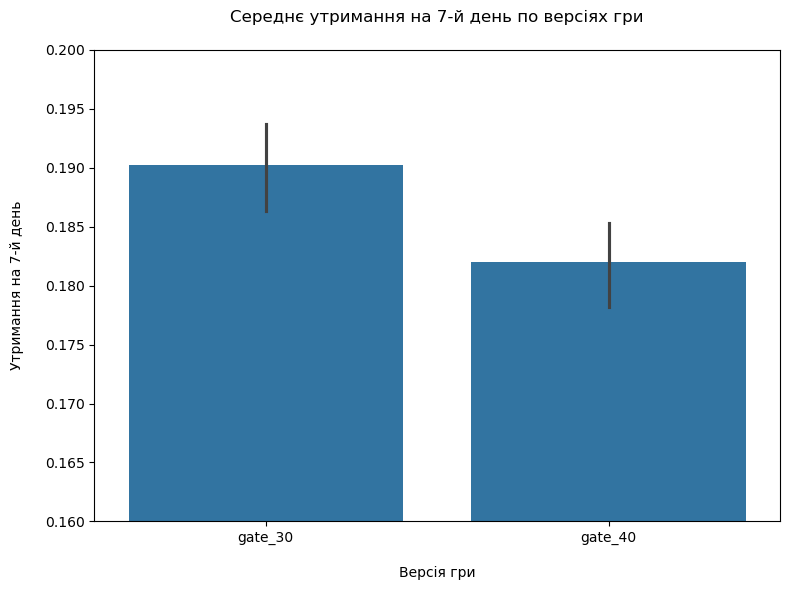

In [60]:
# Будую графік різниці середніх показників між групами
plt.figure(figsize=(8,6))
sns.barplot(x=df['version'], y=df['retention_7'])

plt.ylim(0.16, 0.20)
plt.title('Середнє утримання на 7-й день по версіях гри', pad=20)
plt.xlabel('Версія гри', labelpad=15)
plt.ylabel('Утримання на 7-й день', labelpad=15)
plt.tight_layout()
plt.show()

 **Висновок:**

Cтовпчикова діаграма наочно показує, що версія gate_30 має кращий середній показник утримання. Це свідчить про те, що гравці, які отримали версію з воротами на 30-му рівні, залишаються у грі частіше на 7-й день, ніж ті, хто мав ворота на 40-му рівні.

**Визначаю нульову та альтернативну гіпотези:**

- Нульова гіпотеза $H_о$  :  немає різниці в утриманні між версіями gate_30 та gate_40.
- Альтернативна гіпотеза $H_a$ :   версія gate_30 має краще утримання користувачів на 7-й день після встановлення гри.


3. Перевірте з допомогою пасуючого варіанту z-тесту, чи дає якась з версій гри кращий показник `retention_7` на рівні значущості 0.05. Обчисліть також довірчі інтервали для варіантів до переміщення воріт і після. Виведіть результат у форматі:

    ```
    z statistic: ...
    p-value: ...
    Довірчий інтервал 95% для групи control: [..., ...]
    Довірчий інтервал 95% для групи treatment: [..., ...]
    ```

    де замість `...` - обчислені значення.
    
    В якості висновку дайте відповідь на два питання:  

      1. Чи є статистична значущою різниця між поведінкою користувачів у різних версіях гри?   
      2. Чи перетинаються довірчі інтервали утримання користувачів з різних версій гри? Про що це каже?  


In [58]:
# Визначаю групи
control = df[df['version'] == 'gate_30']
treatment = df[df['version'] == 'gate_40']

# Кількість успіхів та розмір вибірки
successes = np.array([control['retention_7'].sum(), treatment['retention_7'].sum()])
nobs = np.array([control['retention_7'].count(), treatment['retention_7'].count()])

# Z-тест
z_stat, pval = proportions_ztest(successes, nobs)

# Рахую довірчі інтервали
ci_control = proportion_confint(successes[0], nobs[0], alpha=0.05)
ci_treatment = proportion_confint(successes[1], nobs[1], alpha=0.05)

# Виводжу результати
print(f"z-statistic: {z_stat:.3f}")
print(f"p-value: {pval:.3f}")
print(f"Довірчий інтервал 95% для групи control: [{ci_control[0]:.4f}, {ci_control[1]:.4f}]")
print(f"Довірчий інтервал 95% для групи treatment: [{ci_treatment[0]:.4f}, {ci_treatment[1]:.4f}]")

z-statistic: 3.164
p-value: 0.002
Довірчий інтервал 95% для групи control: [0.1866, 0.1938]
Довірчий інтервал 95% для групи treatment: [0.1785, 0.1855]


**Висновки:**

Статистична значущість різниці:
- z-statistic = 3.164.
- p-value = 0.002.

Оскільки 0.002 < 0.05, то нульова гіпотеза **відкидається**. Це означає, що різниця між утриманням користувачів у версіях gate_30 та gate_40 є статистично значущою. Тобто, версія gate_30 дійсно має краще утримання на 7-й день.

Перетин довірчих інтервалів:
- Для групи control (gate_30): [0.1866, 0.1938]
- Для групи treatment (gate_40): [0.1785, 0.1855]

Ці інтервали НЕ перетинаються - різниця між середніми показниками утримання є не лише статистично значущою, але й практично відчутною.

4. Виконайте тест Хі-квадрат на рівні значущості 5% аби визначити, чи є залежність між версією гри та утриманням гравця на 7ий день після реєстрації.

    - Напишіть, як для цього тесту будуть сформульовані гіпотези.
    - Проведіть обчислення, виведіть p-значення і напишіть висновок за результатами тесту.


**Гіпотези:**

- Нульова гіпотеза $H_о$  : версія гри та утримання гравця на 7‑й день незалежні між собою.
- Альтернативна гіпотеза $H_a$ : існує залежність між версією гри та утриманням гравця на 7‑й день.


In [33]:
crosstab = pd.crosstab(df['version'], df['retention_7'])

# Хі-квадрат тест
chi2, p_val, dof, expected = stats.chi2_contingency(crosstab)

print(f"χ² = {chi2:.3f}")
print(f"p-value = {p_val:.3f}")
print(f"Ступені свободи = {dof}")
print("Очікувані частоти:\n", expected)

χ² = 9.959
p-value = 0.002
Ступені свободи = 1
Очікувані частоти:
 [[36382.90257127  8317.09742873]
 [37025.09742873  8463.90257127]]


**Висновок:**

Оскільки 0.002 < 0.05, нульова гіпотеза **відкидається**. Це означає, що існує статистично значуща залежність між версією гри та утриманням користувачів на 7-й день. Версія gate_30 показує вищий рівень утримання, ніж gate_40, і ця різниця не є випадковою.

Тест Хі‑квадрат також підтвердив, що зміна розташування воріт у грі впливає на поведінку користувачів. Версія gate_30 має кращий показник утримання користувачів на 7-й день.